The PCA does an unsupervised dimensionality reduction, while the logistic regression does the prediction.

GridSearchCV is used to set the dimensionality of the PCA.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# Define PCA
pca = PCA()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)

# Define a pipeline to search for the best combination of PCA truncation and classifier regularization
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])

In [3]:
# load data
X_digits, y_digits = datasets.load_digits(return_X_y=True)
X_digits, y_digits

(array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 array([0, 1, 2, ..., 8, 9, 8]))

In [4]:
X_digits.shape, y_digits.shape

((1797, 64), (1797,))

In [5]:
# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60],
    "logistic__C": np.logspace(-4, 4, 4),
}

In [6]:
# search best parameters
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.874):
{'logistic__C': np.float64(21.54434690031882), 'pca__n_components': 60}


In [7]:
# fit pca
pca.fit(X_digits)

PCA()

In [8]:
# create dataframe from cv_results_
best_data = pd.DataFrame(search.cv_results_)
best_data.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.036304,0.013398,0.004556,0.001808,0.0001,5,"{'logistic__C': 0.0001, 'pca__n_components': 5}",0.677778,0.658333,0.662953,0.788301,0.621170,0.681707,0.056463,20
1,0.022699,0.005029,0.004261,0.001372,0.0001,15,"{'logistic__C': 0.0001, 'pca__n_components': 15}",0.775000,0.766667,0.782730,0.857939,0.727019,0.781871,0.042601,16
2,0.021409,0.007182,0.003873,0.001884,0.0001,30,"{'logistic__C': 0.0001, 'pca__n_components': 30}",0.822222,0.811111,0.818942,0.883008,0.779944,0.823045,0.033506,15
3,0.026149,0.009862,0.004827,0.002878,0.0001,45,"{'logistic__C': 0.0001, 'pca__n_components': 45}",0.827778,0.813889,0.824513,0.883008,0.777159,0.825269,0.034014,14
4,0.026295,0.009299,0.006035,0.002860,0.0001,60,"{'logistic__C': 0.0001, 'pca__n_components': 60}",0.830556,0.813889,0.827298,0.883008,0.779944,0.826939,0.033274,13


In [9]:
# drop unnecessary features
best_data = best_data[["param_pca__n_components", "mean_test_score", "std_test_score"]]
best_data

,param_pca__n_components,mean_test_score,std_test_score
0,5,0.681707,0.056463
1,15,0.781871,0.042601
2,30,0.823045,0.033506
3,45,0.825269,0.034014
4,60,0.826939,0.033274
5,5,0.721761,0.036703
6,15,0.868098,0.027605
7,30,0.868117,0.021802
8,45,0.873124,0.026032
9,60,0.873680,0.025433


In [10]:
# check for duplicates
best_data.duplicated().any()

np.True_

In [11]:
# drop duplicates
best_data = best_data.drop_duplicates()

In [12]:
#group by param_pca__n_components

group_max_mean = best_data.groupby("param_pca__n_components")["mean_test_score"].max()
group_max_mean

,mean_test_score
param_pca__n_components,
5,0.721761
15,0.868098
30,0.868117
45,0.873124
60,0.874236


In [13]:
# create a dataframe with unique number of components with max mean test score
#empty list
rows_to_concat = []

#iterate item, values in groups
for i, v in group_max_mean.items():
  #print(i)
  #print(v)
  # Select rows from best_data that match the current n_components and its maximum mean_test_score
  filtered_rows_for_component = best_data.loc[(best_data['param_pca__n_components'] == i) & (best_data['mean_test_score'] == v)]
  #print(filtered_rows_for_component)
  rows_to_concat.append(filtered_rows_for_component)

# Concatenate all collected DataFrames into a single DataFrame
conditions = pd.concat(rows_to_concat, ignore_index=True)

conditions

,param_pca__n_components,mean_test_score,std_test_score
0,5,0.721761,0.036703
1,15,0.868098,0.027605
2,30,0.868117,0.021802
3,45,0.873124,0.026032
4,60,0.874236,0.023914


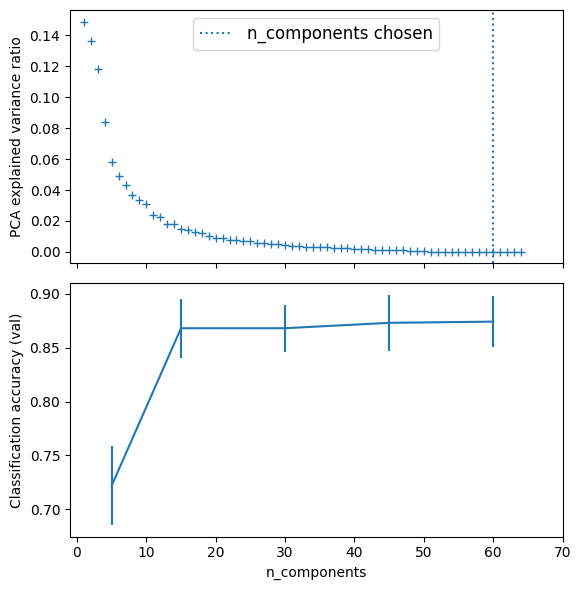

In [14]:
# plot the PCA spectrum

# x - the estimated number of components
# y - the percentage of variance explained by each of the selected components
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

# vertical line - the best number of components, chosen by GridSearchCV
ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
ax1.errorbar(
    conditions['param_pca__n_components'],
    conditions["mean_test_score"],
    yerr=conditions["std_test_score"],
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()
